This notebook is used for evaluating the trained models on different splis and visualizing the batch effect

In [1]:
import sys
import os

src_path = os.path.split(os.getcwd())[0]
sys.path.insert(0, src_path)

import numpy as np
import torch
import json
import torch.nn as nn
from argparse import Namespace
import matplotlib.pyplot as plt
from notebooks import test_utils


model_name = "ResNet50"
test_file = "/system/user/publicwork/sanchez/datasets/jumpcp-indices/indices/source_3_filtered_good_batches.pq"
mapping = "/system/user/studentwork/seibezed/bachelor/data/class_mapping.json"
image_path = "/system/user/publicdata/jumpcp/"
loss_fn = nn.CrossEntropyLoss()
SEED=1234
cross_validation_splits=5

#load mapping
id_mapping = "/system/user/studentwork/seibezed/bachelor/data/id_mapping.json"
with open(id_mapping, "r") as f:
    id_to_class = json.load(f)


## ERM

In [2]:
#crop
#epochs = [13, 21, 28, 15, 21]
#log_path = "/system/user/studentwork/seibezed/bachelor/logs/method=erm_preprocess=crop_imgres=[250]_lr=0.001_wd=0.0001_model=ResNet50_world_size=4batchsize=16_workers=4_date=2025-12-27-21-14-54_"
#rotate
epochs = [18, 67, 16, 15, 31]
log_path = "/system/user/studentwork/seibezed/bachelor/logs/method=erm_preprocess=rotate_imgres=[250]_lr=0.001_wd=0.0001_model=ResNet50_world_size=4batchsize=16_workers=4_date=2025-12-31-10-39-42_"

checkpoint_path = [f"{log_path}/fold{fold}/checkpoints/epoch_{epoch}.pt" for fold, epoch in enumerate(epochs)]

In [3]:
args = Namespace(
    method = "erm",
    batch_size = 64,
    workers = 4
)

erm_data = test_utils.main(test_file, checkpoint_path, model_name, image_path, mapping,args)

  0%|          | 0/180 [00:00<?, ?it/s]/system/apps/studentenv/seibezed/jumpcp-py310/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 180/180 [01:25<00:00,  2.09it/s]


In [4]:
erm_accuracies, erm_label_acc = test_utils.compute_metrics(erm_data, id_to_class)

Individual acc: [0.8213541666666667, 0.7943362498823973, 0.45894097222222224, 0.8254095441595442, 0.7900365153886281]
Test set: 
 Mean: 0.7380154896638917
 Std: 0.14024539727214344

 Accuracy per label
Fold 1
JCP2022_035095: 0.9708333333333333
JCP2022_046054: 0.9902777777777778
JCP2022_064022: 0.9930555555555556
JCP2022_085227: 0.7194444444444444
JCP2022_012818: 0.61875
JCP2022_025848: 0.8638888888888889
JCP2022_037716: 0.9923611111111111
JCP2022_050797: 0.4222222222222222
Fold 2
JCP2022_035095: 0.9084084084084084
JCP2022_046054: 0.9474474474474475
JCP2022_064022: 0.8321995464852607
JCP2022_085227: 0.539039039039039
JCP2022_012818: 0.9289493575207861
JCP2022_025848: 0.5187687687687688
JCP2022_037716: 0.9084084084084084
JCP2022_050797: 0.7724867724867724
Fold 3
JCP2022_035095: 0.6027777777777777
JCP2022_046054: 0.8458333333333333
JCP2022_064022: 0.3284722222222222
JCP2022_085227: 0.019444444444444445
JCP2022_012818: 0.9965277777777778
JCP2022_025848: 0.006944444444444444
JCP2022_037716:

In [5]:
#compute accuracy per meta-batch
batch_acc = {}
for pred, labels, metadata in erm_data:
    batch_acc = {}
    for i in metadata["batch"].unique():
        filter_pred = pred[metadata["batch"]==i]
        filter_labels = labels[metadata["batch"]==i]
        filter_pred = torch.argmax(filter_pred, dim=1)
        correct = (filter_pred == filter_labels).sum().item()
        acc = correct/len(filter_pred)

        key = i
        if key not in batch_acc:
            batch_acc[key] = []
        batch_acc[key].append(acc)

    for key, value in batch_acc.items():
        
        print(f"{key}: {np.mean(value)}")
    print()



CP59: 0.8503472222222223
CP60: 0.7923611111111111

CP_28_all_Phenix1: 0.8728691723146437
CP_32_all_Phenix1: 0.7279513888888889

CP59: 0.5496527777777778
CP_32_all_Phenix1: 0.36822916666666666

CP_27_all_Phenix1: 0.8753472222222223
CP_29_all_Phenix1: 0.772843567251462

CP_31_all_Phenix1: 0.7378962034134448
CP60: 0.8420138888888888



## ARM-CML

In [6]:
#crop
#epochs = [58, 48, 55, 53, 18]
#log_path = "/system/user/studentwork/seibezed/bachelor/logs/method=armcml_preprocess=crop_imgres=[250]_lr=0.001_wd=0.0001_model=ResNet50_world_size=4batchsize=32_workers=1_date=2026-01-05-16-30-54_"
#rotate
epochs = [31, 71, 28, 58, 46]
log_path = "/system/user/studentwork/seibezed/bachelor/logs/method=armcml_preprocess=rotate_imgres=[250]_lr=0.001_wd=0.0001_model=ResNet50_world_size=4batchsize=32_workers=1_date=2026-01-06-17-16-01_"

checkpoint_path = [f"{log_path}/fold{fold}/checkpoints/epoch_{epoch}.pt" for fold, epoch in enumerate(epochs)]

In [7]:
data = []
args = Namespace(
    method = "armcml",
    support_size_eval=256,
    meta_batch_size_eval=1,
    adapt_bn = False,
    n_context_channels=5
)
armcml_data = test_utils.main(test_file, checkpoint_path, model_name, image_path, mapping,args)

100%|██████████| 44/44 [01:33<00:00,  2.12s/it]


In [8]:
armcml_accuracies, armcml_label_acc = test_utils.compute_metrics(armcml_data, id_to_class)

Individual acc: [0.8865451388888889, 0.8588033536585366, 0.8405381944444444, 0.9263263081395349, 0.8990589488636364]
Test set: 
 Mean: 0.8822543887990083
 Std: 0.030110894275144896

 Accuracy per label
Fold 1
JCP2022_035095: 0.9677881173944166
JCP2022_046054: 0.9971408148677627
JCP2022_064022: 0.9931365820178449
JCP2022_085227: 0.8875614898102601
JCP2022_012818: 0.702893436838391
JCP2022_025848: 0.757313829787234
JCP2022_037716: 0.9897680763983628
JCP2022_050797: 0.8030199039121483
Fold 2
JCP2022_035095: 0.9352351580570547
JCP2022_046054: 0.9512378094523631
JCP2022_064022: 0.9010263929618768
JCP2022_085227: 0.7300850734725445
JCP2022_012818: 0.9093774625689519
JCP2022_025848: 0.7252081756245269
JCP2022_037716: 0.950832672482157
JCP2022_050797: 0.772459499263623
Fold 3
JCP2022_035095: 0.9283204497540407
JCP2022_046054: 0.9610655737704918
JCP2022_064022: 0.9476510067114094
JCP2022_085227: 0.5829351535836177
JCP2022_012818: 0.8967468175388967
JCP2022_025848: 0.7148760330578512
JCP2022_037

## ARM-BN

In [9]:
#crop
#epochs = [52, 79, 19, 68, 49]
#log_path = "/system/user/studentwork/seibezed/bachelor/logs/method=armbn_imgres=[250]_lr=0.001_wd=0.0001_agg=True_model=ResNet50_world_size=4batchsize=64_workers=1_date=2025-12-25-10-33-44_"
#rotate
epochs = [59, 87, 19, 52, 58]
log_path = "/system/user/studentwork/seibezed/bachelor/logs/method=armbn_preprocess=rotate_imgres=[250]_lr=0.001_wd=0.0001_model=ResNet50_world_size=4batchsize=64_workers=1_date=2025-12-31-22-50-47_"

checkpoint_path = [f"{log_path}/fold{fold}/checkpoints/epoch_{epoch}.pt" for fold, epoch in enumerate(epochs)]

In [10]:
args = Namespace(
    method = "armbn",
    support_size_eval=256,
    meta_batch_size_eval=1
)
armbn_data = test_utils.main(test_file, checkpoint_path, model_name, image_path, mapping,args)
    

100%|██████████| 44/44 [01:34<00:00,  2.16s/it]


In [11]:
armbn_accuracies, armbn_label_acc = test_utils.compute_metrics(armbn_data, id_to_class)

Individual acc: [0.9248263888888889, 0.8670922256097561, 0.8184895833333333, 0.9298691860465116, 0.9054509943181818]
Test set: 
 Mean: 0.8891456756393344
 Std: 0.04165577763830709

 Accuracy per label
Fold 1
JCP2022_035095: 0.9808743169398907
JCP2022_046054: 0.9971264367816092
JCP2022_064022: 0.988628762541806
JCP2022_085227: 0.9101754385964912
JCP2022_012818: 0.8187009279086367
JCP2022_025848: 0.863314447592068
JCP2022_037716: 0.9965564738292011
JCP2022_050797: 0.8397565922920892
Fold 2
JCP2022_035095: 0.9055177626606198
JCP2022_046054: 0.9569486404833837
JCP2022_064022: 0.9243515850144092
JCP2022_085227: 0.759375
JCP2022_012818: 0.9000751314800901
JCP2022_025848: 0.7761976047904192
JCP2022_037716: 0.945839874411303
JCP2022_050797: 0.7588709677419355
Fold 3
JCP2022_035095: 0.9135628952916374
JCP2022_046054: 0.9577464788732394
JCP2022_064022: 0.9371980676328503
JCP2022_085227: 0.6170212765957447
JCP2022_012818: 0.84
JCP2022_025848: 0.6610526315789473
JCP2022_037716: 0.9500346981263011


## ARMLL

In [12]:
#crop
#epochs = [102, 153, 100, 53, 37]
#log_path = "/system/user/studentwork/seibezed/bachelor/logs/method=armll_preprocess=crop_imgres=[250]_lr=0.001_wd=0.0001_model=ResNet50_world_size=4batchsize=16_workers=1_date=2025-12-28-19-23-19_"
#rotate
epochs = [42, 187, 43, 124, 106]
log_path = "/system/user/studentwork/seibezed/bachelor/logs/method=armll_preprocess=rotate_imgres=[250]_lr=0.001_wd=0.0001_model=ResNet50_world_size=4batchsize=16_workers=1_date=2026-01-02-13-15-41_"

checkpoint_path = [f"{log_path}/fold{fold}/checkpoints/epoch_{epoch}.pt" for fold, epoch in enumerate(epochs)]

In [13]:
args = Namespace(
    method = "armll",
    support_size_eval=32,
    meta_batch_size_eval=1,
    inner_lr = 0.1,
    n_inner_iter = 1
)
armll_data =test_utils.main(test_file, checkpoint_path, model_name, image_path, mapping,args)

100%|██████████| 359/359 [01:32<00:00,  3.87it/s]


In [14]:
armll_accuracies, armll_label_acc = test_utils.compute_metrics(armll_data, id_to_class)

Individual acc: [0.7485243055555556, 0.8537274096385542, 0.7142361111111111, 0.9143518518518519, 0.8850974930362117]
Test set: 
 Mean: 0.823187434238657
 Std: 0.07812998158516138

 Accuracy per label
Fold 1
JCP2022_035095: 0.9687924016282226
JCP2022_046054: 0.9978991596638656
JCP2022_064022: 0.9774281805745554
JCP2022_085227: 0.5394736842105263
JCP2022_012818: 0.5746575342465754
JCP2022_025848: 0.6697247706422018
JCP2022_037716: 0.9914529914529915
JCP2022_050797: 0.2669461914744934
Fold 2
JCP2022_035095: 0.9084668192219679
JCP2022_046054: 0.9528158295281582
JCP2022_064022: 0.8810975609756098
JCP2022_085227: 0.6676579925650558
JCP2022_012818: 0.9282990083905416
JCP2022_025848: 0.7767341040462428
JCP2022_037716: 0.9543754674644727
JCP2022_050797: 0.767175572519084
Fold 3
JCP2022_035095: 0.9126279863481229
JCP2022_046054: 0.9151724137931034
JCP2022_064022: 0.9336071184120466
JCP2022_085227: 0.23870967741935484
JCP2022_012818: 0.8248914616497829
JCP2022_025848: 0.3201413427561837
JCP2022_0

## Memo

In [2]:
#crop
epochs = [13, 21, 28, 15, 21]
log_path = "/system/user/studentwork/seibezed/bachelor/logs/method=erm_preprocess=crop_imgres=[250]_lr=0.001_wd=0.0001_model=ResNet50_world_size=4batchsize=16_workers=4_date=2025-12-27-21-14-54_"
#rotate
#epochs = [18, 67, 16, 15, 31]
#log_path = "/system/user/studentwork/seibezed/bachelor/logs/method=erm_preprocess=rotate_imgres=[250]_lr=0.001_wd=0.0001_model=ResNet50_world_size=4batchsize=16_workers=4_date=2025-12-31-10-39-42_"

checkpoint_path = [f"{log_path}/fold{fold}/checkpoints/epoch_{epoch}.pt" for fold, epoch in enumerate(epochs)]

In [ ]:
args = Namespace(
    method = "memo",
    batch_size = 64,
    workers = 4,
    k_augmentations=8,
    memo_opt = "AdamW",
    memo_lr = 1e-5,
    memo_wd = 1e-4,
    memo_steps = 1,
    severity = 1,
    prior_strength = -1,
    seed=SEED,
    subset = True                      #for debugging
)
np.random.seed(SEED)
torch.manual_seed(SEED)
memo_data =test_utils.main(test_file, checkpoint_path, model_name, image_path, mapping,args)

  0%|          | 0/8 [00:00<?, ?it/s]/system/apps/studentenv/seibezed/jumpcp-py310/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 8/8 [00:26<00:00,  3.26s/it]


In [ ]:
memo_accuracies, memo_label_acc = test_utils.compute_metrics(memo_data, id_to_class)

Individual acc: [0.7977777777777778, 0.8533333333333334, 0.8533333333333334, 0.8244444444444444, 0.8311111111111111]
Test set: 
 Mean: 0.8320000000000001
 Std: 0.020684580050169075

 Accuracy per label
Fold 1
JCP2022_035095: 0.9444444444444444
JCP2022_046054: 0.9452054794520548
JCP2022_064022: 0.7735849056603774
JCP2022_085227: 0.9444444444444444
JCP2022_012818: 0.8837209302325582
JCP2022_025848: 0.6779661016949152
JCP2022_037716: 0.9245283018867925
JCP2022_050797: 0.32786885245901637
Fold 2
JCP2022_035095: 0.9811320754716981
JCP2022_046054: 0.9696969696969697
JCP2022_064022: 0.9387755102040817
JCP2022_085227: 0.8524590163934426
JCP2022_012818: 0.9272727272727272
JCP2022_025848: 0.7058823529411765
JCP2022_037716: 0.9482758620689655
JCP2022_050797: 0.49122807017543857
Fold 3
JCP2022_035095: 0.9444444444444444
JCP2022_046054: 0.958904109589041
JCP2022_064022: 0.9245283018867925
JCP2022_085227: 0.6481481481481481
JCP2022_012818: 0.9534883720930233
JCP2022_025848: 0.5254237288135594
JCP202

## TENT

In [18]:
#crop
#epochs = [13, 21, 28, 15, 21]
#log_path = "/system/user/studentwork/seibezed/bachelor/logs/method=erm_preprocess=crop_imgres=[250]_lr=0.001_wd=0.0001_model=ResNet50_world_size=4batchsize=16_workers=4_date=2025-12-27-21-14-54_"
#rotate
epochs = [18, 67, 16, 15, 31]
log_path = "/system/user/studentwork/seibezed/bachelor/logs/method=erm_preprocess=rotate_imgres=[250]_lr=0.001_wd=0.0001_model=ResNet50_world_size=4batchsize=16_workers=4_date=2025-12-31-10-39-42_"

checkpoint_path = [f"{log_path}/fold{fold}/checkpoints/epoch_{epoch}.pt" for fold, epoch in enumerate(epochs)]

In [19]:
args = Namespace(
    method = "tent",
    batch_size = 64,
    workers = 4,
    tent_lr = 0.002,
    tent_momentum = 0.9,
    tent_steps = 1,
    episodic = False
)
np.random.seed(SEED)
torch.manual_seed(SEED)
tent_data =test_utils.main(test_file, checkpoint_path, model_name, image_path, mapping,args)

100%|██████████| 180/180 [00:41<00:00,  4.32it/s]


In [20]:
tent_accuracies, tent_label_acc = test_utils.compute_metrics(tent_data, id_to_class)

Individual acc: [0.8772569444444445, 0.8555837802239157, 0.8330729166666667, 0.8740206552706553, 0.8884541818814119]
Test set: 
 Mean: 0.8656776956974188
 Std: 0.01942890137967754

 Accuracy per label
Fold 1
JCP2022_035095: 0.9631944444444445
JCP2022_046054: 0.9923611111111111
JCP2022_064022: 0.9888888888888889
JCP2022_085227: 0.8930555555555556
JCP2022_012818: 0.7472222222222222
JCP2022_025848: 0.8284722222222223
JCP2022_037716: 0.9930555555555556
JCP2022_050797: 0.6118055555555556
Fold 2
JCP2022_035095: 0.9061561561561562
JCP2022_046054: 0.9436936936936937
JCP2022_064022: 0.9040060468631897
JCP2022_085227: 0.6614114114114115
JCP2022_012818: 0.9168556311413454
JCP2022_025848: 0.7394894894894894
JCP2022_037716: 0.9527027027027027
JCP2022_050797: 0.8208616780045351
Fold 3
JCP2022_035095: 0.9166666666666666
JCP2022_046054: 0.9625
JCP2022_064022: 0.9701388888888889
JCP2022_085227: 0.71875
JCP2022_012818: 0.8423611111111111
JCP2022_025848: 0.6048611111111111
JCP2022_037716: 0.93125
JCP2022

## Visualizations

In [21]:
#collect data
data = [erm_data,armcml_data, armbn_data,armll_data, memo_data, tent_data]
accs = [erm_accuracies, armcml_accuracies,armbn_accuracies,armll_accuracies, memo_accuracies, tent_accuracies]
label_accs = [erm_label_acc, armcml_label_acc,armbn_label_acc,armll_label_acc,memo_label_acc, tent_label_acc]


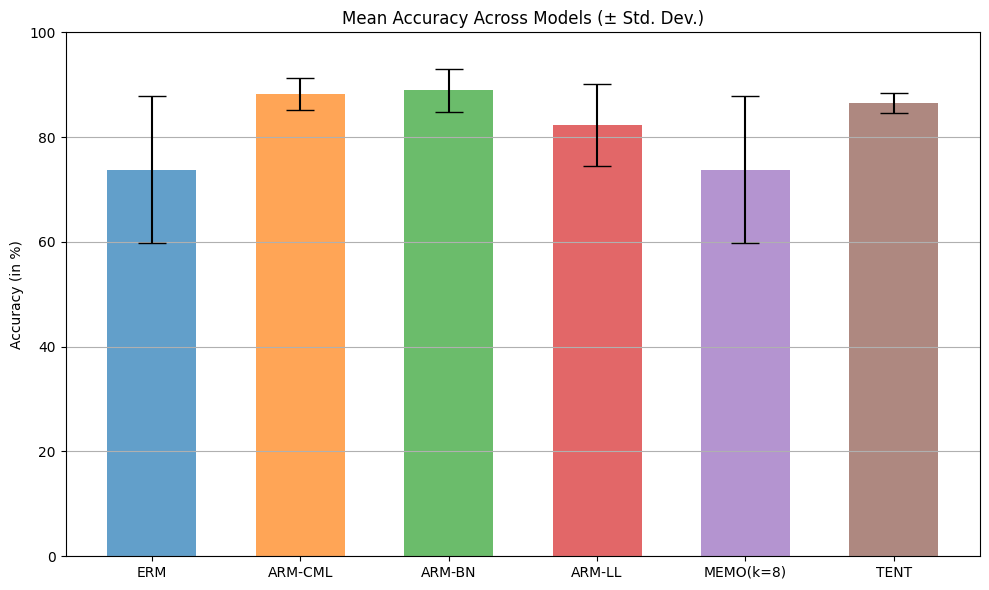

In [22]:
#barplot with erro bars
model_names = ["ERM", "ARM-CML","ARM-BN", "ARM-LL", "MEMO(k=8)", "TENT"]
bar_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

means = []
stds= []
for model_acc in accs:
    means.append(100*np.mean(model_acc))
    stds.append(100*np.std(model_acc))

x = range(1,12,2)

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x, means, width =1.2, alpha=0.7, yerr=stds, align='center', ecolor="black", capsize=10,color = bar_colors)
ax.set_ylabel("Accuracy (in %)")
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0,100)
ax.yaxis.grid(True)
ax.set_title("Mean Accuracy Across Models (± Std. Dev.)")

plt.tight_layout()
plt.savefig("rotate_avgacc.png")
plt.show()


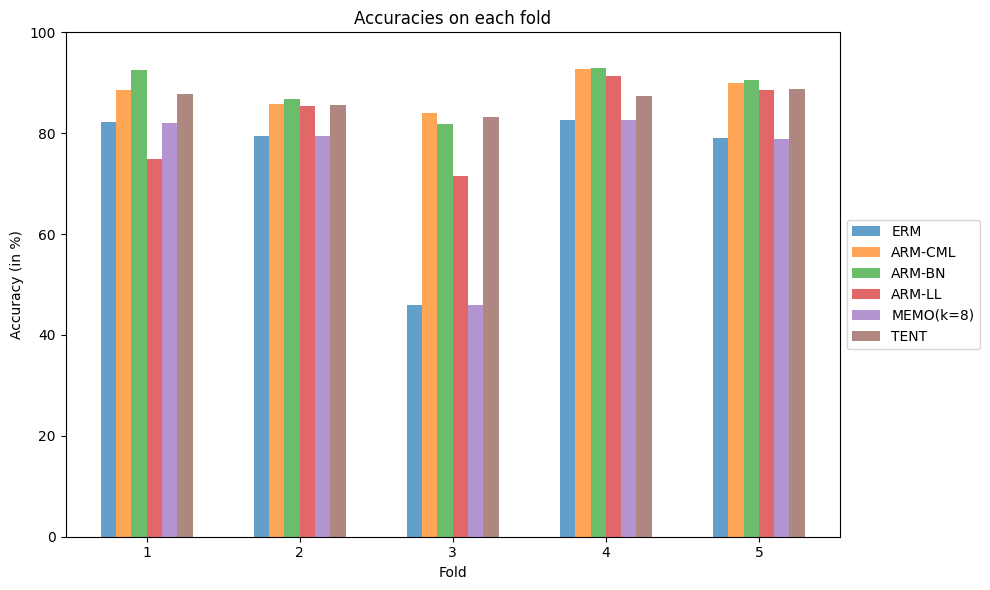

In [23]:
#barplot of accuracies
x = np.arange(5)+1
model_names = ["ERM", "ARM-CML","ARM-BN", "ARM-LL", "MEMO(k=8)", "TENT"]
bar_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for i,(d,c,n) in enumerate(zip(accs,bar_colors, model_names)):
    d = [100*dacc for dacc in d]
    ax.bar(x+(0.1*(i-2.5)), d, width=0.1,alpha=0.7,color=c, align='center', label=n)
ax.set_xlabel("Fold")
ax.set_ylabel("Accuracy (in %)")
ax.set_ylim(0,100)
ax.set_title("Accuracies on each fold")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("rotate_allacc.png")
plt.show()

    


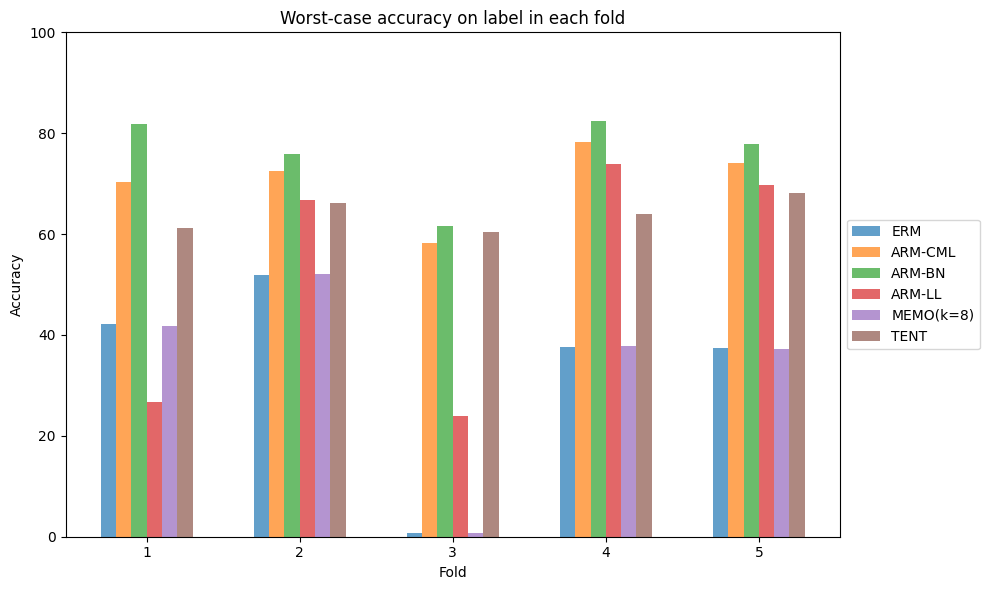

In [24]:
#barplot of worst case accuracies
x = np.arange(5)+1
model_names = ["ERM", "ARM-CML","ARM-BN", "ARM-LL", "MEMO(k=8)", "TENT"]
bar_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for i,(d,c,n) in enumerate(zip(label_accs,bar_colors, model_names)):
    worst_case = []
    for fold in d:
        worst_case.append(100*np.min(fold))
    ax.bar(x+(0.1*(i-2.5)), worst_case, width=0.1,alpha=0.7,color=c, align='center', label=n)
ax.set_xlabel("Fold")
ax.set_ylabel("Accuracy")
ax.set_ylim(0,100)
ax.set_title("Worst-case accuracy on label in each fold")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig("rotate_allworstacc.png")
plt.show()

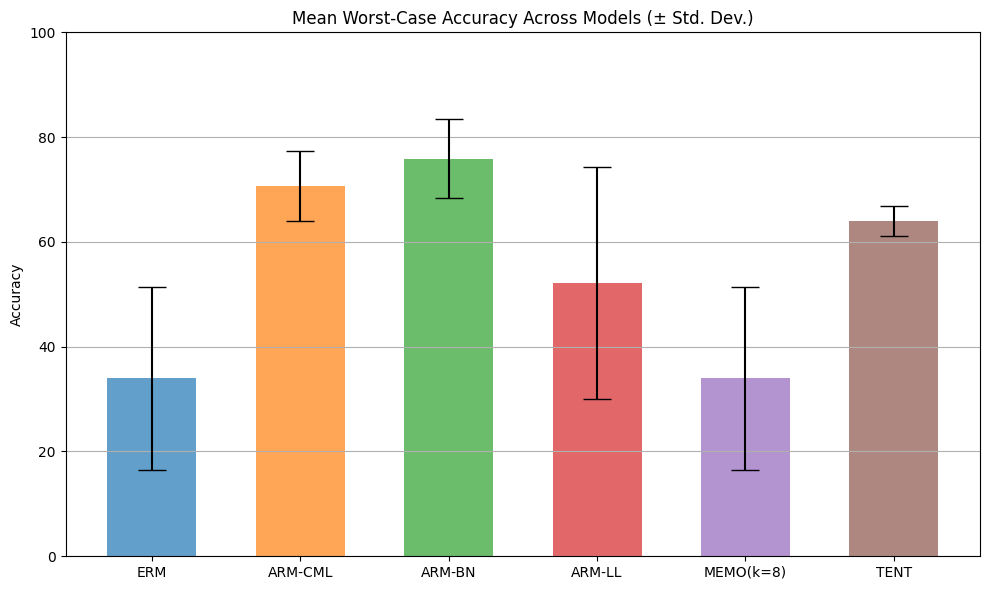

: 

In [ ]:
model_names = ["ERM", "ARM-CML","ARM-BN", "ARM-LL", "MEMO(k=8)", "TENT"]
bar_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

worst_means = []
worst_stds= []

for i,(d,c,n) in enumerate(zip(label_accs,bar_colors, model_names)):
    worst_case = []
    for fold in d:
        worst_case.append(np.min(fold))
    worst_means.append(100*np.mean(worst_case))
    worst_stds.append(100*np.std(worst_case))


x = range(1,12,2)

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x, worst_means, width =1.2, alpha=0.7, yerr=worst_stds, align='center', ecolor="black", capsize=10,color = bar_colors)
ax.set_ylabel("Accuracy")
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0,100)
ax.yaxis.grid(True)
ax.set_title("Mean Worst-Case Accuracy Across Models (± Std. Dev.)")


plt.tight_layout()
plt.savefig("rotate_avgworstacc.png")
plt.show()
